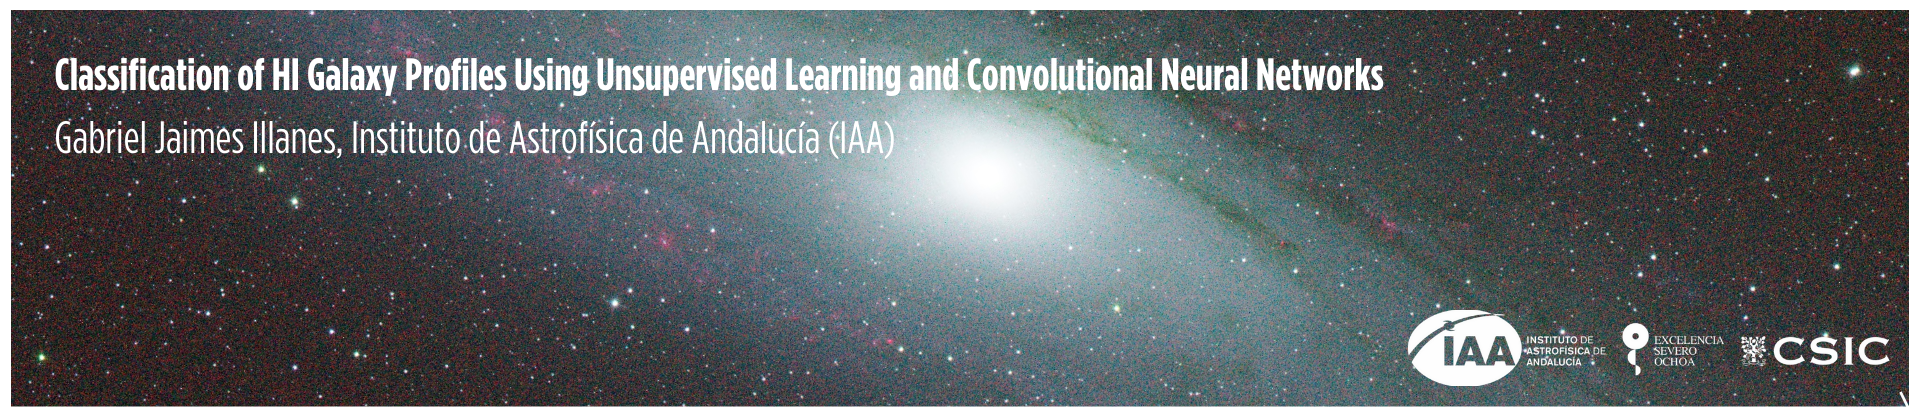

---

<div style="text-align: center;">
    <h2>PROFILE FITTING USING BUSYFIT</h2>
</div>



---

### Step 1: FITS File Inspection and Table Extraction

This code inspects FITS files in a specified directory and generates text files containing extracted tabular data. Initially, the script imports necessary libraries for handling files, processing FITS data, and managing data tables. It identifies all FITS files in the given directory and processes each to extract any tables contained within. The extracted tables are converted into pandas DataFrames, concatenated if multiple tables are found, and then saved into text files with a `.txt` extension. Each text file includes column headers as comments, and the data is written in a space-separated format. The code also handles cases where no tables are found by printing a relevant message.


In [ ]:
!pip install subprocess32 regex numpy astropy matplotlib
Profile Fitting using Busyfit

In [2]:
# 1.--------- Library importation -----------
import os
from astropy.io import fits
import pandas as pd

# 2.--------- Function to inspect all FITS files in a directory -----------
def inspect_all_fits_files(input_dir):
    # Get the list of FITS files in the directory
    fits_files = [f for f in os.listdir(input_dir) if f.endswith('.fits')]
    
    # Loop through each FITS file in the directory
    for fits_file in fits_files:
        file_path = os.path.join(input_dir, fits_file)
        output_file = os.path.join(input_dir, f"{fits_file}.txt")
        
        # Call the function to inspect individual FITS file
        inspect_fits_file(file_path, output_file)

# 3.--------- Function to inspect a single FITS file and extract tables -----------
def inspect_fits_file(file_path, output_file):
    # Open the FITS file
    with fits.open(file_path) as hdul:
        # Create a list to store all found DataFrames of tables
        all_dfs = []
        
        # Iterate over each HDU (Header/Data Unit)
        for hdu in hdul:
            # Check if the HDU contains a table (binary or regular table)
            if isinstance(hdu, fits.BinTableHDU) or isinstance(hdu, fits.TableHDU):
                # Convert the table to a pandas DataFrame and add it to the list
                df = pd.DataFrame(hdu.data)
                all_dfs.append(df)
        
        # 4.--------- Process and save the extracted data if tables are found -----------
        # Concatenate all DataFrames into one if any are found
        if all_dfs:
            final_df = pd.concat(all_dfs, ignore_index=True)
            
            # Save the DataFrame into the output file with space-separated columns
            with open(output_file, 'w') as f:
                # Write the first line as a comment with column names
                f.write("# " + ' '.join(final_df.columns) + '\n')
                
                # Iterate over each row of the DataFrame in reverse order and write the data
                for index, row in final_df[::-1].iterrows():
                    line = ' '.join(map(str, row)) + '\n'
                    f.write(line)
        else:
            # If no tables are found, print a message
            print(f"No tables found in the FITS file: {file_path}")

# 5.--------- Define the working directory and call the inspection function -----------
# Current directory
current_dir = '/media/sf_1._JAE_Intro_ICU/sp_testVM'

# Inspect all FITS files in the current directory
inspect_all_fits_files(current_dir)


### Step 2: FITS and PNG File Generation with Busyfit

This script processes ASCII data files using the `busyfit` tool to perform fitting operations and generate FITS and PNG files. It begins by importing necessary libraries for file operations, data handling, and plotting. The script defines input and output directories, ensures the output directory exists, and lists all `.asc` files in the input directory. It limits the number of files to process and specifies a range of files based on their indices.

Utility functions are defined for saving parameters to files, executing `busyfit` commands, and saving data as FITS and PNG files. The script processes each selected file by executing a series of `busyfit` commands with different parameters. It extracts fitting parameters from the command output, adjusts fitting windows based on these parameters, and saves results in FITS and PNG formats. If parameter extraction fails at any step, the script prints an error message.

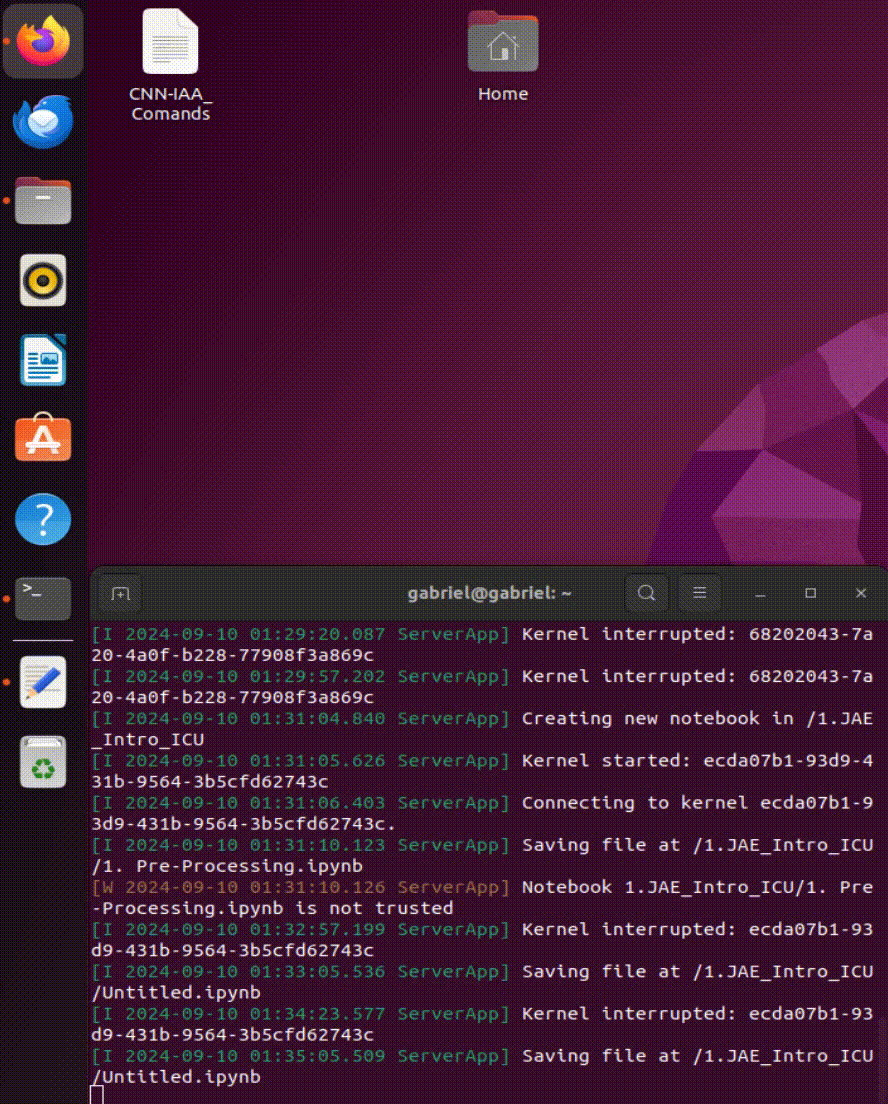

In [ ]:
# 1.--------- Library importation -----------
import subprocess
import re
import os
import numpy as np
from astropy.io import fits
import matplotlib.pyplot as plt

# 2.--------- Directory paths -----------
# Define the input and output directories
input_dir = r'/media/sf_1._JAE_Intro_ICU/CIG/ascii-files/'
output_dir = r'/media/sf_1._JAE_Intro_ICU/CIG/ascii-files/sp_busyfit_testVM'

# 3.--------- Ensure output directory exists -----------
# Ensure that the output directory exists, create it if it does not
os.makedirs(output_dir, exist_ok=True)

# 4.--------- List all .txt files in the input directory -----------
# List all .asc files in the input directory
txt_files = [file for file in os.listdir(input_dir) if file.endswith('.asc')]
txt_files.sort()  # Sort the files alphabetically

# 5.--------- Limit the number of files to process -----------
# Set the limit for the number of files to process (adjustable)
nfiles = 31500
txt_files = txt_files[:nfiles]

# 6.--------- Define the range of files to process -----------
# Define the range of files to be processed by start and end indices
start_file = 1  # Start index (inclusive)
end_file = 1000  # End index (exclusive)
txt_files = txt_files[start_file:end_file]

# 7.--------- Define utility functions -----------
# Function to save output parameters to a file
def save_parameters_to_file(filename, output):
    with open(filename, 'w') as f:
        f.write(output)

# Function to execute the busyfit command
def execute_busyfit(command):
    process = subprocess.Popen(command, shell=True, stdout=subprocess.PIPE, stderr=subprocess.PIPE)
    output, error = process.communicate()
    return output.decode('utf-8'), error.decode('utf-8')

# Function to save data as FITS and plot PNG files
def save_fits_and_png(data_file, fits_filename, plt_filename):
    try:
        # Load the data from the file
        data = np.loadtxt(data_file)
        
        # Save the data in a FITS file
        fits_data = np.array([data[:, 1]])  # Save only the column of flux values
        fits.writeto(fits_filename, fits_data, overwrite=True)
        #print(f"Saved {fits_filename}")
    except Exception as e:
        print(f"Error saving {fits_filename}: {str(e)}")
    
    # Plot and save as PNG
    try:
        plt.figure(figsize=(8, 6))
        plt.plot(data[:, 0], data[:, 1], 'k-')  # Black line plot for the data
        plt.axis('off')  # Turn off axis display
        plt.savefig(plt_filename, bbox_inches='tight', pad_inches=0, dpi=300)
        plt.close()
    except Exception as e:
        print(f"Error saving {plt_filename}: {str(e)}")

# 8.--------- Loop over all the selected files -----------
# Process each selected file in the range
for txt_file in txt_files:
    gal = os.path.splitext(txt_file)[0]  # Get the galaxy name (filename without extension)
    txt_filepath = os.path.join(input_dir, txt_file)  # Full path to the text file

    # 9.--------- First fit with busyfit -----------
    command_1 = f"busyfit '{txt_filepath}'"  # First busyfit command
    output_1, error_1 = execute_busyfit(command_1)  # Execute the command and capture output
    subprocess.run("sleep 0.5 && pkill gnuplot", shell=True)  # Kill gnuplot after a short delay

    # Save the first set of parameters and the corresponding FITS and PNG files
    save_parameters_to_file(os.path.join(output_dir, f"{gal}_param_1.dat"), output_1)
    save_fits_and_png('busyfit_output_fit.txt', os.path.join(output_dir, f'{gal}_busyfit_1.fits'), os.path.join(output_dir, f'{gal}_busyfit_1.png'))

    # Extract 'Pos' and 'w50' from the first output using regex
    pos_match_1 = re.search(r'Pos\s+=\s+([0-9.]+)', output_1)
    w50_match_1 = re.search(r'w50\s+=\s+([0-9.]+)', output_1)

    # If the first fit was successful and values were extracted
    if pos_match_1 and w50_match_1:
        pos_1 = float(pos_match_1.group(1))  # Extract position
        w50_1 = float(w50_match_1.group(1))  # Extract w50 value

        # Calculate new parameters for the second adjustment
        P1_1 = round(pos_1 - (w50_1) - 2)
        P2_1 = round(pos_1 + (w50_1) + 2)

        # 10.--------- Second fit with busyfit -----------
        command_2 = f"busyfit '{txt_filepath}' -w {P1_1} {P2_1}"  # Second busyfit command with windowing
        output_2, error_2 = execute_busyfit(command_2)  # Execute the second fit
        subprocess.run("sleep 0.5 && pkill gnuplot", shell=True)  # Kill gnuplot

        # Save the second set of parameters and FITS/PNG files
        save_parameters_to_file(os.path.join(output_dir, f"{gal}_param_2.dat"), output_2)
        save_fits_and_png('busyfit_output_fit.txt', os.path.join(output_dir, f'{gal}_busyfit_2.fits'), os.path.join(output_dir, f'{gal}_busyfit_2.png'))

        # Extract 'Pos' and 'w50' from the second output
        pos_match_2 = re.search(r'Pos\s+=\s+([0-9.]+)', output_2)
        w50_match_2 = re.search(r'w50\s+=\s+([0-9.]+)', output_2)

        # If the second fit was successful, proceed to third fit
        if pos_match_2 and w50_match_2:
            pos_2 = float(pos_match_2.group(1))  # Extract position from second fit
            w50_2 = float(w50_match_2.group(1))  # Extract w50 from second fit

            # Calculate new parameters for the third adjustment
            P1_2 = round(pos_2 - (w50_2) - 5)
            P2_2 = round(pos_2 + (w50_2) + 5)

            # 11.--------- Third fit with busyfit -----------
            command_3 = f"busyfit '{txt_filepath}' -w {P1_2} {P2_2}"  # Third busyfit command with updated window
            output_3, error_3 = execute_busyfit(command_3)  # Execute third fit
            subprocess.run("sleep 0.0 && pkill gnuplot", shell=True)  # Kill gnuplot

            # Save the third set of parameters and FITS/PNG files
            save_parameters_to_file(os.path.join(output_dir, f"{gal}_param_3.dat"), output_3)
            save_fits_and_png('busyfit_output_fit.txt', os.path.join(output_dir, f'{gal}_busyfit_3.fits'), os.path.join(output_dir, f'{gal}_busyfit_3.png'))
    else:
        print(f"Could not extract 'Pos' and 'w50' from the output of {txt_file}.")
